# TITLE: Velocity Optimization for Repeatable Highway Travel
# Author: Samuel Law
---

## Step 1: Derive the Equations of Motion
---

In [97]:
%reset -f

In [98]:
import sympy as sm
import sympy.physics.mechanics as me
from IPython.display import display, Latex
import warnings
me.init_vprinting()

In [99]:
def eprint(lhs: str, rhs: str) -> display:
    eq = f"${lhs} = {rhs}$"
    return display(Latex(eq))

If we take the system to be a simplified car acted upon by gravity, which is a constant, friction which is a function dominated by air resistance, and tau, the torque of the motor we can derive the equations of motion using Kanes Method. To elemenate uncessary complexity, a 2D model will be used. 

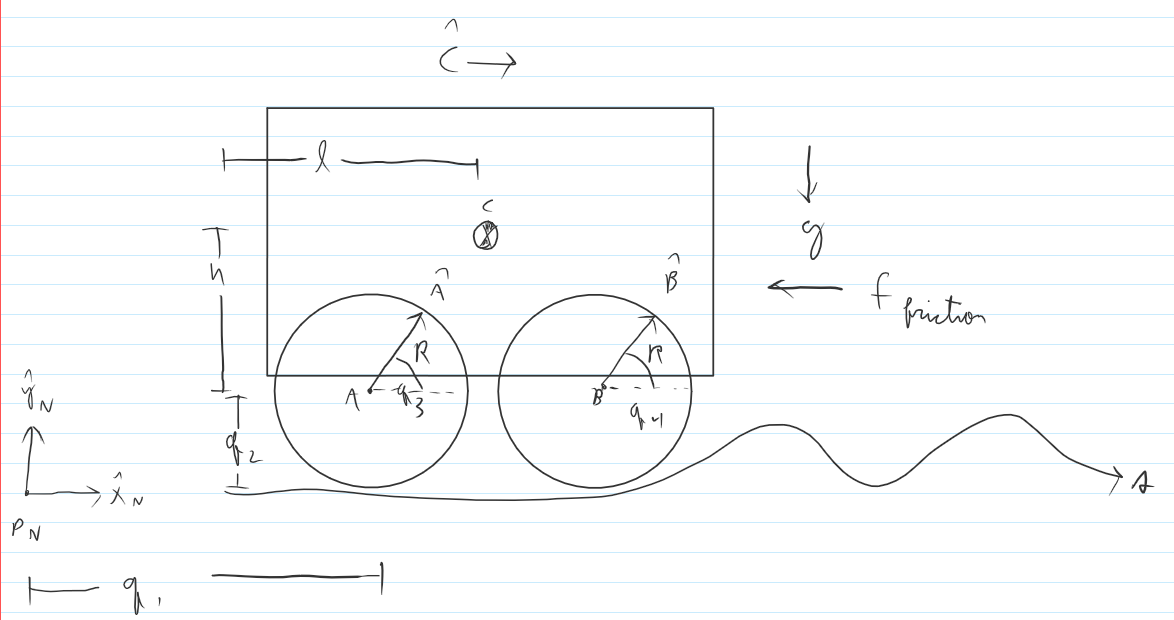

The following assumptions will be made to reduce the complexity further.
1. The change in position from rear wheel (body A) to any other point on the car will be neglected.
2. From 1. we get that this is essentially a point mass with a rotating component and a static component.

In [100]:
# define the inertial frame
N = me.ReferenceFrame('N')
pN = me.Point('pN')
pN.set_vel(N, 0)

In [101]:
# define independent general coordinates
q1, u1 = me.dynamicsymbols('q1, u1')
q1d, u1d = me.dynamicsymbols('q1, u1', 1)

In [102]:
# define variables
R, t = sm.symbols('R, t')
# R is the wheel radius
# t is used for integration later

Define dependent generalized coordinate q2 using place holder function and the following formula:

$\quad \large{\frac{dq_2}{dq_1}\frac{dq_1}{dt} = \frac{dq_2}{dt} = \dot{q_2}} \quad$ (derivation of $\dot{q_2}$)

In [103]:
# q2 (the y component) is a funciton of q1 as described by the 
# equation defining the road surface which is unknown at this point.

q2 = sm.Function('q2')(q1)  # function place holder
q2prime = sm.diff(q2, q1)   # tangent line
q2d = q2prime*q1d           # time derivative of q2

In [104]:
eprint('q_2', me.vlatex(q2))
eprint('q_{2}prime', me.vlatex(q2prime))
eprint('\dot{q_2}', me.vlatex(q2d))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Define dependent generalized coordinate q3 in terms of q2 using the following formulas:

$\quad s = \int_{a}^{b} \sqrt{1 + f\prime\left(x\right)^2}dx\qquad$(general form for arc length)

$\quad \large{q_3 = \frac{-s}{R}}\qquad\qquad\qquad $ ($q_3$ constraint equation)

$\quad \large{\dot{q_3} = \frac{-\dot{s}}{R}}\qquad\qquad\qquad $ ($\dot{q_3}$ constraint equation)

* $R$ = radius of the wheel
* $q_2\prime$ is the slope of the road at point x
* s is the length of the arc traveled


In [105]:
# q3 is a function of the arc length s, the general form of which 
# is shown above.

s = sm.integrate(sm.sqrt(1 + q2prime**2), (q1, 0, q1))  # arc length (integrated from 0 to q1)
sd = sm.diff(s, t)                                      # change in arc length with respect to time
q3 = -s/R
q3d = -sd/R

In [106]:
eprint('q_3', me.vlatex(q3))
eprint('\dot{q_3}', me.vlatex(q3d))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [107]:
# create the bodies
# rear wheels
bodyA = me.Body(
    name='bA',
    masscenter=pN.locatenew('pA', q1*N.x + q2*N.y),
    frame=N.orientnew('A', 'axis', (q3, N.z))
)
# car body
bodyB = me.Body(
    name='bB',
    masscenter=bodyA.masscenter.locatenew('pB', 0),
    frame=N.orientnew('B', 'axis', (sm.atan(q2prime), N.z))
)

In [108]:
# create the kinematic constraints
kde = [(q1d - u1)]  # kinematic differential equations

KM = me.KanesMethod(
    frame=N,     # frame in which to solve the problem 
    q_ind=[q1],  # independent generalized coordinate
    u_ind=[u1],  # independent generalized speed
    kd_eqs=kde   # equation defining gen-co to gen-speed
)

In [109]:
# define the active loads acting on the system
f, tau, g = sm.symbols('f, tau, g')
loads = [ # assuming the vehical is traveling in +x direction
    # forces (point, vector)
    (bodyA.masscenter, f*-bodyA.frame.x),
    (bodyA.masscenter, bodyA.mass*g*-N.y),
    (bodyB.masscenter, bodyB.mass*g*-N.y),
    # moments (frame, vector)
    (bodyA.frame, tau*-bodyA.frame.z)
]
bodies = [bodyA, bodyB]
Fr, Fr_star = KM.kanes_equations(bodies, loads)

In [110]:
eprint('Fr', me.vlatex(Fr))

<IPython.core.display.Latex object>

In [111]:
eprint('Fr^*', me.vlatex(Fr_star))

<IPython.core.display.Latex object>

In [112]:
sol = sm.solve([Fr + Fr_star], [u1d], dict=True)
print(f'{len(sol)} solutions found')

1 solutions found


## Step 2: Create Callables from the Equations of Motion

Estimate the mass using the following sources<br>
[link to ford focus mass info](https://g.co/kgs/MCnbgJ)<br>
[link to wheel mass info](https://www.focusst.org/threads/st-stock-wheel-weight.268/#:~:text=Registered,-Joined%20Aug%2013&text=The%20stock%20Focus%20ST%20wheel,Weight%20is%2025lbs.)<br>
* The assumption was made to treat the wheel as a solid disk.
* The assumption was also made to model all the wheels as one body.
* The assumption was also made to model the cab as another body.
* The effects of wheel height above the road, and distance from the front of the to the back of the cab <br>
  are all neglected as the actual geometry of the car is not necessary for the model to be accurate.

In [113]:
# convertion functions
in2m = lambda x: x*25.4/1000
lb2kg = lambda x: x*0.453592

# base values
vals = {
    # lengths
    R: in2m(9.5),                # meters
    
    # accelerations
    g: 9.81,                     # m/s^2
    
    # masses
    bodyA.mass: 4*lb2kg(25),     # kg, both back wheels
    bodyB.mass: lb2kg(3000),     # kg, car
}

# derived values
vals.update({ 
    # moments of intertia
    'bA_izz': 0.5*vals[bodyA.mass]*vals[R],  # kg*m^2
    'bB_izz': 0.5*vals[bodyB.mass]*vals[R],  # kg*m^2
})

In [114]:
# create a list of arguments necessary to compute q1dd at any point q1
dq2dq1_1 = sm.diff(q2, q1, 1)  # first derivative of q2(q1) with respect to q1
dq2dq1_2 = sm.diff(q2, q1, 2)  # second derivative of q2(q1) with respect to q1
dq2dq1_3 = sm.diff(q2, q1, 3)  # third derivative of q2(q1) with respect to q1
args = [q1, u1, dq2dq1_1, dq2dq1_2, dq2dq1_3, f, tau]

In [115]:
# create the acceleration callable using the known values & arguments
Q1DD = sol[0][u1d]                                     # extract the solution for q1dd
Q1DD = me.msubs(Q1DD.subs(vals), vals)                 # sub in known values
Q1DD_FUNC = sm.lambdify(args, Q1DD, modules='numpy')   # create the function
Q1DD_FUNC(0, 0, 0, 0, 0, 0, 0)                         # test call it

In [116]:
eprint('\dot{s}', me.vlatex(sd))

<IPython.core.display.Latex object>

In [117]:
args = [q1, q1d, dq2dq1_1, dq2dq1_2]              # list of arguments for above expression
SD_FUNC = sm.lambdify(args, sd, modules='numpy')  # create the callable
SD_FUNC(0, 0, 0, 0)                               # test the callable

---

## Step 4: Perform Basic Simulation to Validate Equations

In [118]:
import math as m
import numpy as np
from scipy.integrate import RK45
from matplotlib import pyplot as plt

In [119]:
%matplotlib inline

Create and display the fake road data

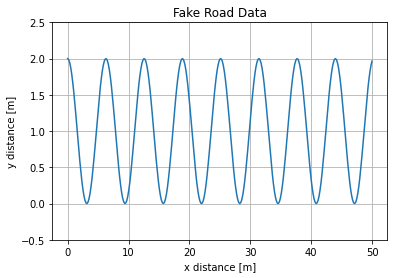

In [120]:
x_vec = np.linspace(0, 50, 300)
y_vec = np.cos(x_vec) + 1
fig, ax = plt.subplots()
ax.plot(x_vec, y_vec)
ax.grid()
ax.set_ylim([-0.5, 2.5])
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.set_title('Fake Road Data');

Run a simulation based on it

In [121]:
# create the necessary inputs from the equation modeling the road surface.
q2_func = sm.cos(q1) + 1            # known function
dq2dq1_1 = sm.diff(q2_func, q1, 1)  # first derivative
dq2dq1_2 = sm.diff(q2_func, q1, 2)  # second derivative
dq2dq1_3 = sm.diff(q2_func, q1, 3)  # third derivative
f, tau = 0, 0                       # constants

# create a callable to speed up the simulation
dq2dq1_func = sm.lambdify([q1], [dq2dq1_1, dq2dq1_2, dq2dq1_3], modules='numpy')
dq2dq1_func(0)

run and RK45 simulation with inital velcity

In [122]:
# state variables
#   x1 = q1,    x1d = q1d
#   x2 = q1d,   x2d = q1dd

def model(t, x):
    q1, q1d = x
    dq2dq1_1, dq2dq1_2, dq2dq1_3 = dq2dq1_func(q1)
    q1dd = Q1DD_FUNC(q1, q1d, dq2dq1_1, dq2dq1_2, dq2dq1_3, f, tau)
    return q1d, q1dd       

In [123]:
x0 = np.array([0.1, 1])                               # initial conditions
t0 = 0.0                                              # start time
tf = 50                                               # final time
integrator = RK45(model, t0, x0, tf, max_step=0.05)   # integrator object
results = np.array([t0, *x0])                         # results vector

while True:
    try: integrator.step();
    except Exception as e: print(e); break;
    else: results = np.vstack([results, (integrator.t, *integrator.y)]);

Attempt to step on a failed or finished solver.


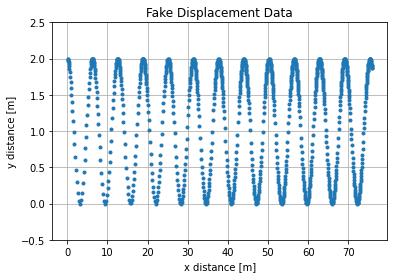

In [124]:
q1_vec = results[:, 1]
q2_vec = np.cos(q1_vec) + 1
fix, ax = plt.subplots()
ax.plot(q1_vec, q2_vec, '.')
ax.grid();
ax.set_ylim([-0.5, 2.5])
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.set_title('Fake Displacement Data');

Run the RK45 simulation without initial velocity

In [125]:
x0 = np.array([0.1, 0])                               # initial conditions
t0 = 0.0                                              # start time
tf = 50                                               # final time
integrator = RK45(model, t0, x0, tf, max_step=0.05)   # integrator object
results = np.array([t0, *x0])                         # results vector

while True:
    try: integrator.step();
    except Exception as e: print(e); break;
    else: results = np.vstack([results, (integrator.t, *integrator.y)]);

Attempt to step on a failed or finished solver.


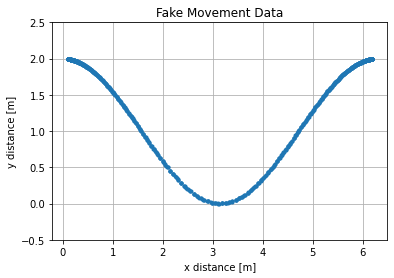

In [126]:
q1_vec = results[:, 1]
q2_vec = np.cos(q1_vec) + 1
fix, ax = plt.subplots()
ax.plot(q1_vec, q2_vec, '.')
ax.grid();
ax.set_ylim([-0.5, 2.5])
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.set_title('Fake Movement Data');

Analysis: <br>
Our results for the equations of motion appear to be correct as the simulations reflect what we expect to happen. In the first simulation with an initial speed, given, the vehical travels infinitly. In the second simulation with no initial velociy and a slight offset, the vehical oscillates infinitly. This is exactly what we expect from a system with no damping. 

___

## Step 4: Clean & Format GPX Data

In [127]:
import gpxpy
import gpxpy.gpx
import ipywidgets as ipw
from numpy.polynomial.polynomial import Polynomial, polyval, polyder

Parse the gpx file

In [128]:
FILE_NAME = 'COURSE_50421442.gpx'

points = []  # empty container
with open(FILE_NAME, 'r') as f: 
    # this library really really REALLY SUCKS, but it's already
    # made and I don't want to reinvent the wheel. 
    gpx_data = gpxpy.parse(f.read())
    track, *_ = gpx_data.tracks
    segment, *_ = track.segments
    points.extend(segment.points)

The formula used to calculate the distance between markers can be found found [here](https://www.kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python)

In [129]:
def dist_from_points(p1, p2):
    """Returns the distance in kilometers
    between two points using the Haversine formula."""
    # radius of the Earth
    R = 6373.0  
    
    # coordinates in radians
    lat1 = np.radians(p1.latitude)
    lon1 = np.radians(p1.longitude)
    lat2 = np.radians(p2.latitude)
    lon2 = np.radians(p2.longitude)
    
    # coordinate deltas
    dlon = lon2 - lon1  
    dlat = lat2 - lat1
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    kilometers = R * c
    
    return kilometers

In [130]:
# calculate deltas between the points
deltas = [dist_from_points(p1, p2) for p1, p2 in zip(points[:], points[1:])]

# convert to metes
km2m = lambda x: x*1000
deltas = [km2m(x) for x in deltas]

In [131]:
# calculate total distance at each point
x_vals = [0]
for i, d in enumerate(deltas, start=1):
    x_vals.append(x_vals[i-1] + d) 

# ensure values are floats
x_vals = [float(x) for x in x_vals]

In [132]:
# calculate the elevation at each point
y_vals = [p.elevation for p in points]

# ensure values are floats
y_vals = [float(y) for y in y_vals]

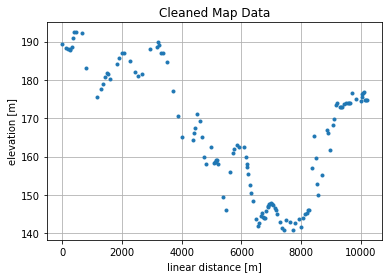

In [133]:
# plot the cleaned data
fig, ax = plt.subplots()
ax.plot(x_vals, y_vals, '.')
ax.grid()
ax.set_xlabel('linear distance [m]')
ax.set_ylabel('elevation [m]')
ax.set_title('Cleaned Map Data');

## Step 5: Interactively Curve Fit the Data
---

Because we know that highways do not change direction suddenly or have 
sharp points we will fit the data using polynomial fitting.

In [134]:
# What we want to happen on slider change
poly = [None]   # using a list as a python pointer helps keep
                # poly from being overwritten inside of func.
def func(n):
    # curve fit poly of degree n
    poly[0] = (Polynomial.fit(x_vals, y_vals, n))
    # generate data points from the curve fit
    x_ = np.linspace(0, 10_000, 5000)
    # use convert to use "pure coefficients"
    y_ = poly[0](x_)  
    # plot cleaned data and the fit
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x_vals, y_vals, '.', label='cleaned data')
    ax.plot(x_, y_, label=f'polyfit deg={n}')
    ax.grid(); ax.legend()
    ax.set_xlabel('linear distance [m]')
    ax.set_ylabel('elevation [m]')
    ax.set_title('Curve Fit Map Data');

# create our slider
ipw.interact(
    func, 
    n=ipw.IntSlider(min=2, max=50, value=27, description='n'),
);

interactive(children=(IntSlider(value=27, description='n', max=50, min=2), Output()), _dom_classes=('widget-in…

## Step 6. Perform Simulation on Curve Fit Equations
---

In [135]:
# create necessary inputs
p = poly[0]        # polynomial for q2(q1)
dp1 = p.deriv()    # first derivative of q2(q1) with respect to q1
dp2 = dp1.deriv()  # first derivative of q2(q1) with respect to q1
dp3 = dp2.deriv()  # first derivative of q2(q1) with respect to q1
f, tau = 0, 0      # constants

In [136]:
# state variables
#   x1 = q1,    x1d = q1d
#   x2 = q1d,   x2d = q1dd

def model(t, x):
    q1, q1d = x
    dq2dq1_1 = dp1(q1)  
    dq2dq1_2 = dp2(q1) 
    dq2dq1_3 = dp3(q1)
    q1dd = Q1DD_FUNC(q1, q1d, dq2dq1_1, dq2dq1_2, dq2dq1_3, f, tau)
    return q1d, q1dd       

In [137]:
x0 = np.array([600, 0])                               # initial conditions
t0 = 0.0                                              # start time
tf = 3600                                             # final time
lower_bound, upper_bound = poly[0].domain             # distnace based event flags
eps = 1e-11                                           # stillness based event threashold
integrator = RK45(model, t0, x0, tf, max_step=1)      # integrator object
results = np.array([t0, *x0])                         # results vector

while True:
    try: integrator.step();
    except Exception as e: print(e); break;
    else: 
        results = np.vstack([results, (integrator.t, *integrator.y)])
        # boundry event detection
        if (lower_bound > integrator.y[0]) or (integrator.y[0] > upper_bound): 
            print('out of bounds'); break
        # equalibrium event detection
        elif abs(results[-2, 1] - results[-1, 1]) < eps:
            print('not moving'); break

out of bounds


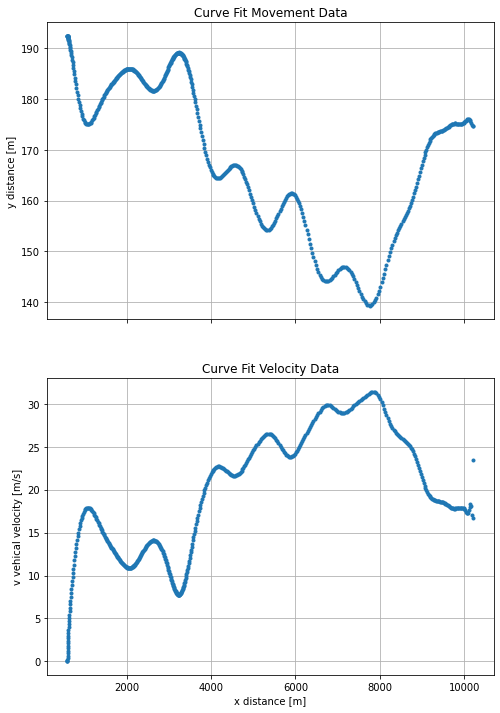

In [138]:
# generate the position data
q1_vec = results[:, 1]  # extract x data
q2_vec = p(q1_vec)      # generate y data

# generate the ground speed data
q1d_vec = results[:, 2]     # extract xd data
dq1dq2_1_vec = dp1(q1_vec) 
dq1dq2_2_vec = dp2(q1_vec)   
sd_vec = SD_FUNC(q1_vec, q1d_vec, dq1dq2_1_vec, dq1dq2_2_vec)

# create the plot
fix, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 12), sharex=True, squeeze=True)
ax1.plot(q1_vec, q2_vec, '.')
ax2.plot(q1_vec, sd_vec, '.')
ax1.grid(); ax2.grid();
ax1.set_ylabel('y distance [m]')
ax1.set_title('Curve Fit Movement Data');
ax2.set_xlabel('x distance [m]')
ax2.set_ylabel('v vehical velocity [m/s]')
ax2.set_title('Curve Fit Velocity Data');